# Predicting raindfall for World Food Program

Rainfall is an important factor affecting people's livelihoods: if it deviates from the season's averages it can impact agricultural production. Rainfall therefore is an important data stream that we use in WFP to monitor food security.

The goal of this notebook is to train a model that predicts rainfall in a given region given historical rainfall estimates. The dataset consists of rainfall estimates in a number of regions worldwide indexed by region (AdminCode), year, month, and decade (one month is made of 3 decades). The goal is to predict the rainfall per region for the next 3 decades (i.e. t+1, t+2, t+3).

The data can be downloaded from here:
https://wfp-public.oss-eu-central-1.aliyuncs.com/tmp/rainfall_by_country.csv.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

import random
from collections import Counter 

In [2]:
data = pd.read_csv('rainfall_by_country.csv')

In [3]:
data.head()

AdminCode  mean_rainfall  year  month  decade
0        273          1.613  1990      1       1
1        274        103.433  1990      1       1
2        276        140.389  1990      1       1
3        277         61.144  1990      1       1
4        278          0.000  1990      1       1

### Create `date` column, assuming the decades begin on the 1st, 11th, and 21st of each month

In [4]:
data['day'] = data['decade'] * 10 - 9

In [5]:
data['date'] = pd.to_datetime(data['year'].astype(str) + data['month'].astype(str).str.zfill(2) + data['day'].astype(str).str.zfill(2))

In [6]:
data.head()

AdminCode  mean_rainfall  year  month  decade  day       date
0        273          1.613  1990      1       1    1 1990-01-01
1        274        103.433  1990      1       1    1 1990-01-01
2        276        140.389  1990      1       1    1 1990-01-01
3        277         61.144  1990      1       1    1 1990-01-01
4        278          0.000  1990      1       1    1 1990-01-01

### EDA

In [7]:
data['date'].unique()[:5]

array(['1990-01-01T00:00:00.000000000', '1990-01-11T00:00:00.000000000',
       '1990-01-21T00:00:00.000000000', '1990-02-01T00:00:00.000000000',
       '1990-02-11T00:00:00.000000000'], dtype='datetime64[ns]')

In [8]:
data.describe()

AdminCode  mean_rainfall           year          month  \
count  265620.000000  265620.000000  265620.000000  265620.000000   
mean     3509.388344      32.397389    2004.496725       6.499548   
std     18051.579411      40.552156       8.653691       3.452277   
min         1.000000      -1.000000    1990.000000       1.000000   
25%        75.000000       5.188000    1997.000000       3.000000   
50%       162.000000      18.000000    2004.000000       6.000000   
75%       243.000000      44.611500    2012.000000      10.000000   
max    147299.000000     668.000000    2019.000000      12.000000   

              decade            day  
count  265620.000000  265620.000000  
mean        1.999910      10.999096  
std         0.816517       8.165166  
min         1.000000       1.000000  
25%         1.000000       1.000000  
50%         2.000000      11.000000  
75%         3.000000      21.000000  
max         3.000000      21.000000

##### Why are there several rows with negative mean rainfall? How is that possible?

In [9]:
data[data['mean_rainfall'] < 0]

AdminCode  mean_rainfall  year  month  decade  day       date
122           134           -1.0  1990      1       1    1 1990-01-01
189           216           -1.0  1990      1       1    1 1990-01-01
344           134           -1.0  1990      1       2   11 1990-01-11
411           216           -1.0  1990      1       2   11 1990-01-11
614           134           -1.0  1990      1       3   21 1990-01-21
...           ...            ...   ...    ...     ...  ...        ...
265050        216           -1.0  2019     12       1    1 2019-12-01
265228        134           -1.0  2019     12       2   11 2019-12-11
265295        216           -1.0  2019     12       2   11 2019-12-11
265473        134           -1.0  2019     12       3   21 2019-12-21
265540        216           -1.0  2019     12       3   21 2019-12-21

[2407 rows x 7 columns]

In [10]:
data[data['mean_rainfall'] < 0]['AdminCode'].unique()

array([134, 216, 255,  56], dtype=int64)

134


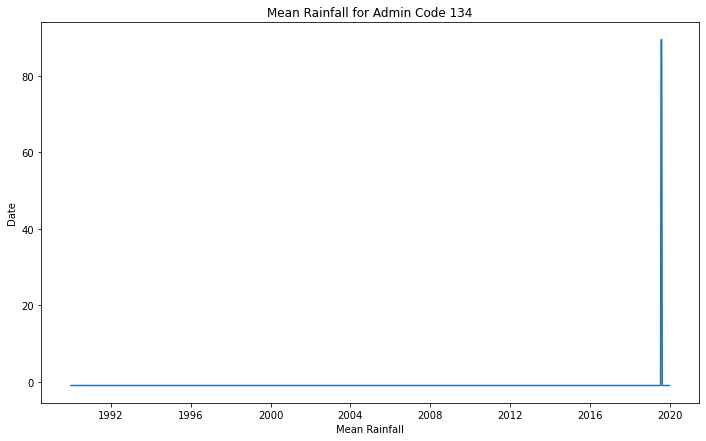

216


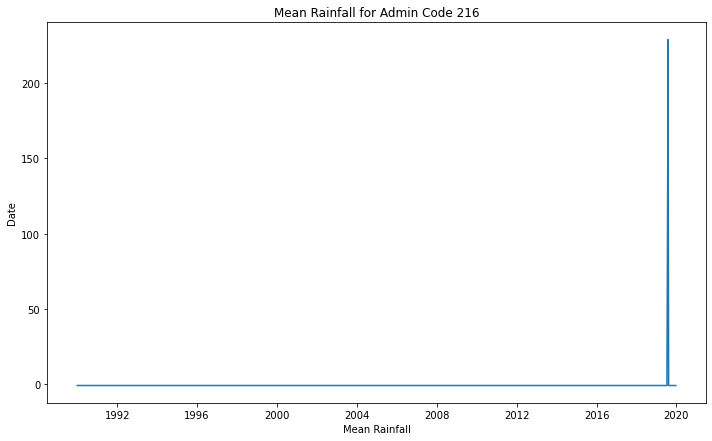

255


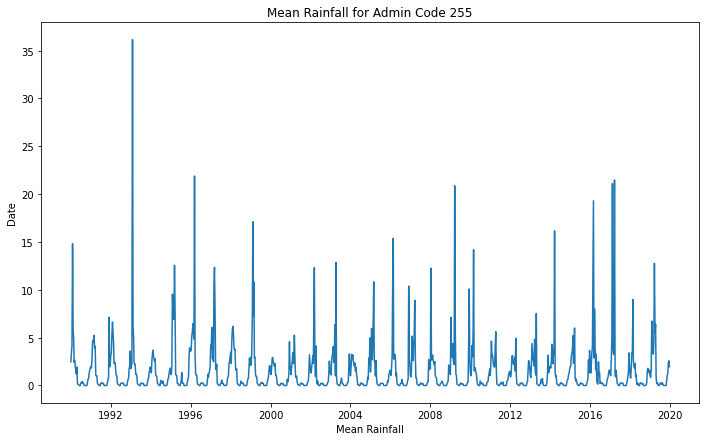

56


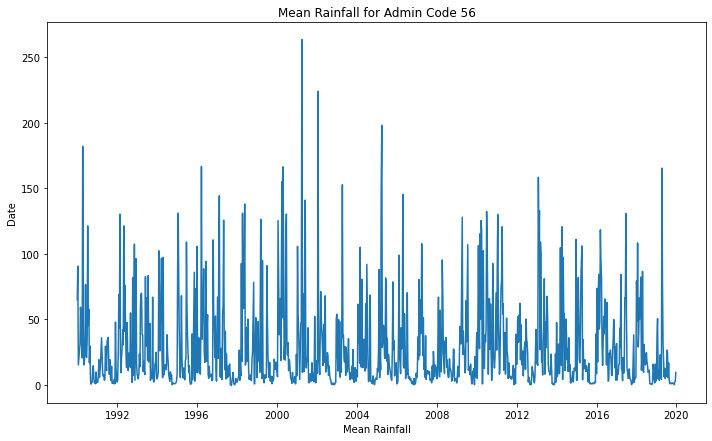

In [11]:
for code in data[data['mean_rainfall'] < 0]['AdminCode'].unique():
    print(code)
    plt.figure(figsize=(11.8, 7))
    plt.plot(data[data['AdminCode'] == code]['date'], data[data['AdminCode'] ==code]['mean_rainfall'])
    plt.title('Mean Rainfall for Admin Code {}'.format(code))
    plt.xlabel('Mean Rainfall')
    plt.ylabel('Date')
    plt.show()

##### Let's drop admin codes 134 and 216. Looks like bad data

In [12]:
data = data[~data['AdminCode'].isin([134, 216])]

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263460 entries, 0 to 265619
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   AdminCode      263460 non-null  int64         
 1   mean_rainfall  263460 non-null  float64       
 2   year           263460 non-null  int64         
 3   month          263460 non-null  int64         
 4   decade         263460 non-null  int64         
 5   day            263460 non-null  int64         
 6   date           263460 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 16.1 MB


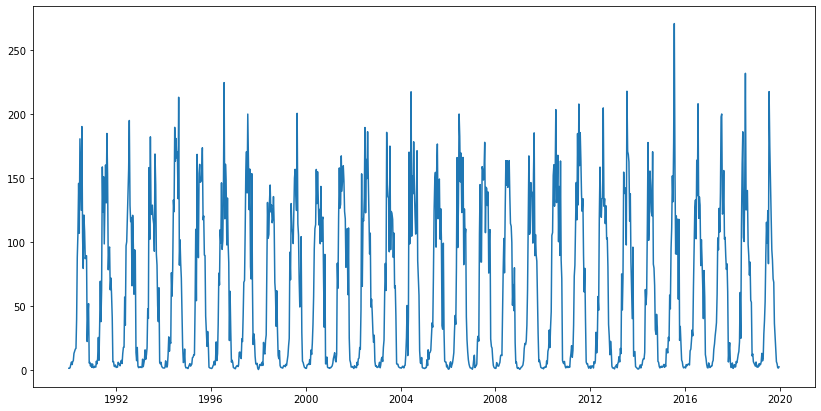

In [14]:
plt.figure(figsize=(14, 7))
plt.plot(data[data['AdminCode'] == 273]['date'], data[data['AdminCode'] == 273]['mean_rainfall'])
plt.show()

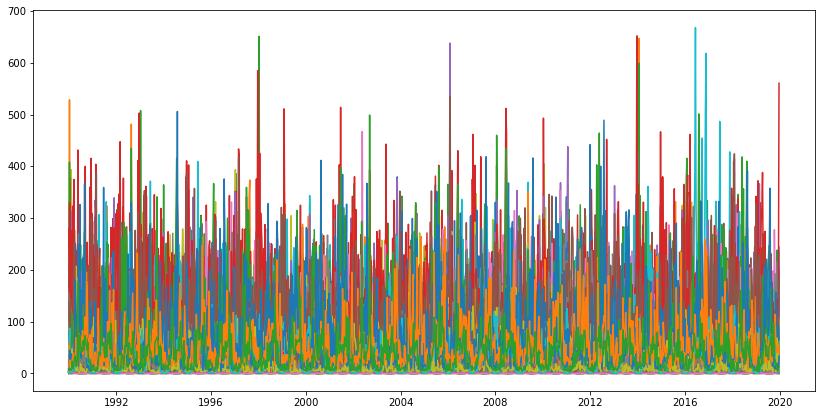

In [15]:
plt.figure(figsize=(14, 7))
for code in data['AdminCode'].unique():
    plt.plot(data[data['AdminCode'] == code]['date'], data[data['AdminCode'] == code]['mean_rainfall'])
plt.show()

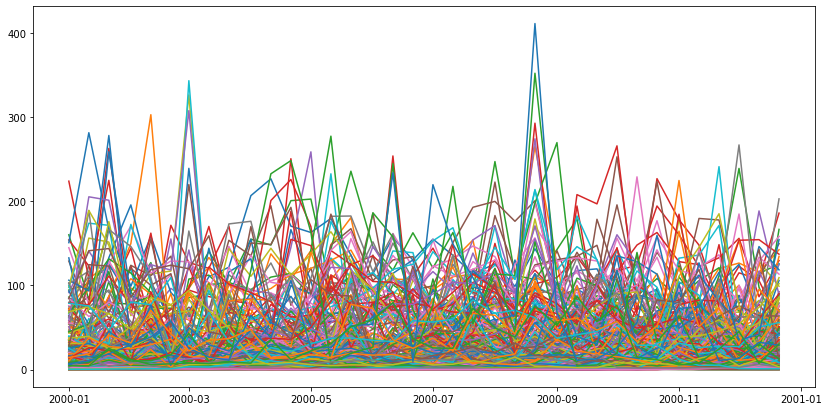

In [16]:
data2000 = data[data['date'].dt.year == 2000]
plt.figure(figsize=(14, 7))
for code in data2000['AdminCode'].unique():
    plt.plot(data2000[data2000['AdminCode'] == code]['date'], data2000[data2000['AdminCode'] == code]['mean_rainfall'])
plt.show()

### Build initial Prophet model

In [17]:
df = pd.DataFrame()
df['ds'] = data['date']
df['y'] = data['mean_rainfall']
# df['cap'] = 15000
df['floor'] = 0  # only used if growth='logistic'

In [18]:
code = 273

prophet = Prophet(growth='linear',
                  yearly_seasonality=False,
                  weekly_seasonality=False,
                  daily_seasonality=False,
                  seasonality_mode='multiplicative',
                  seasonality_prior_scale=10,
                  changepoint_prior_scale=.05
                 ).add_seasonality(name='yearly',
                                    period=365.25,
                                    fourier_order=4,
                                    prior_scale=10,
                                    mode='additive'
                  )

In [19]:
prophet.fit(df[data['AdminCode'] == code])

In [20]:
future = prophet.make_future_dataframe(periods=31, freq='D')
future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

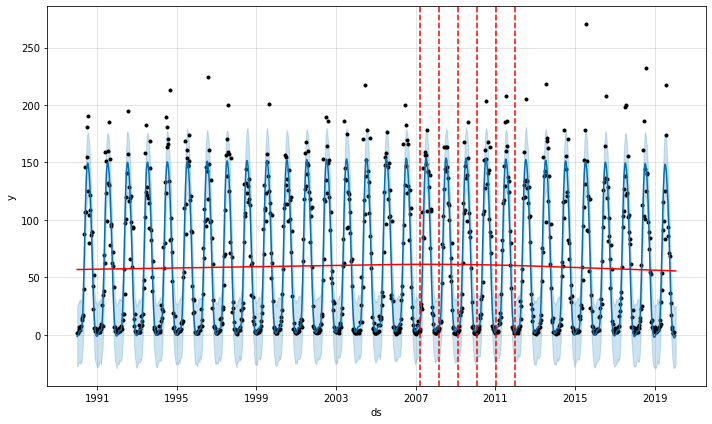

In [21]:
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

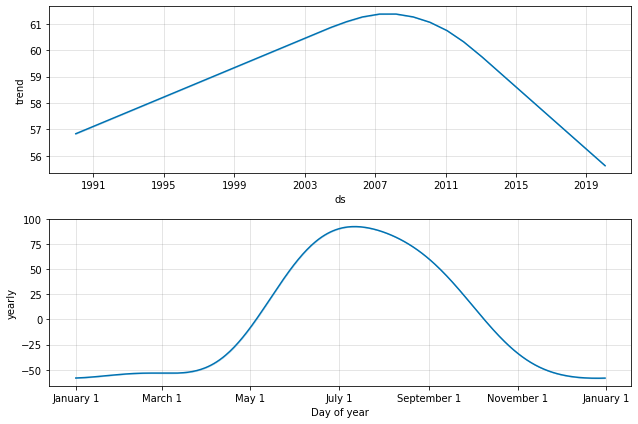

In [22]:
fig2 = prophet.plot_components(forecast)
plt.show()

In [23]:
cutoffs = list(pd.date_range(start='1/1/2001', end='12/31/2019', freq='MS', closed=None))

In [24]:
len(cutoffs)

228

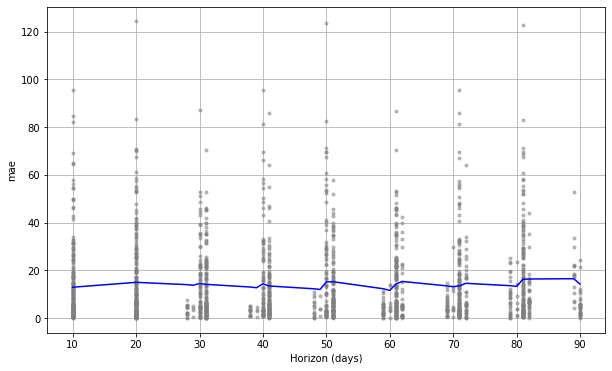

MAE: 13.94


In [25]:
df_cv = cross_validation(prophet, initial='3652 days', period='365 days', horizon = '90 days', cutoffs=cutoffs)
df_p = performance_metrics(df_cv)
fig = plot_cross_validation_metric(df_cv, metric='mae')
plt.show()
print('MAE:', '{:.2f}'.format(df_p['mae'].mean()))

### Hyperparameter tuning

In [26]:
def run_model(admin_code, changepoint_prior_scale, fourier_order, prior_scale, mode):
    prophet = Prophet(growth='linear',
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      changepoint_prior_scale=changepoint_prior_scale
                     ).add_seasonality(name='yearly',
                                        period=365.25,
                                        fourier_order=fourier_order,
                                        prior_scale=prior_scale,
                                        mode=mode
                                        )
    
    prophet.fit(df[data['AdminCode'] == admin_code])
    
    future = prophet.make_future_dataframe(periods=31, freq='D')
    future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

    forecast = prophet.predict(future)
    
    cutoffs = list(pd.date_range(start='1/1/2001', end='12/31/2019', freq='MS', closed=None))
    df_cv = cross_validation(prophet, initial='3652 days', period='365 days', horizon = '90 days', cutoffs=cutoffs, parallel='processes')
    df_p = performance_metrics(df_cv)
    
    rmse = df_p['rmse'].mean()
    print('rmse:', '{:.2f}'.format(rmse))
    return rmse

### Grid search hyperparameters with random sample of admin codes

In [27]:
results = {}

# admin_codes = [1, 273, 274, 278, 147299]
admin_codes = random.sample(data['AdminCode'].unique().tolist(), 5)

changepoint_prior_scales = [.05]  # [.01, .05, .15]
fourier_orders = [4]  # [4, 6, 8]
prior_scales = [10]  # [1, 10, 30]
modes = ['multiplicative']  # ['multiplicative', 'additive']

for admin_code in admin_codes:
    results[admin_code] = []
    for changepoint_prior_scale in changepoint_prior_scales:
        for fourier_order in fourier_orders:
            for prior_scale in prior_scales:
                for mode in modes:
                    params = {'admin_code': admin_code,
                              'changepoint_prior_scale': changepoint_prior_scale,
                              'fourier_order': fourier_order,
                              'prior_scale': prior_scale,
                              'mode': mode}
#                     print(admin_code, changepoint_prior_scale, fourier_order, prior_scale, mode)
                    print(params)
#                     rmse = run_model(admin_code, changepoint_prior_scale, fourier_order, prior_scale, mode)
                    rmse = run_model(**params)
                    results[admin_code].append((rmse, params))
                    print()

{'admin_code': 47, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5D74148>
INFO:fbprophet:Skipping MAPE because y close to 0


rmse: 5.70

{'admin_code': 51, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B48B9D08>


rmse: 13.79

{'admin_code': 197, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B577AB08>


rmse: 20.22

{'admin_code': 214, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5BE76C8>


rmse: 38.05

{'admin_code': 17, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B498DF08>


rmse: 6.69



In [28]:
results = {}

# admin_codes = [1, 273, 274, 278, 147299]
admin_codes = random.sample(data['AdminCode'].unique().tolist(), 20)

changepoint_prior_scales = [.05]  # [.01, .05, .15]
fourier_orders = [4]  # [4, 6, 8]
prior_scales = [10]  # [1, 10, 30]
modes = ['multiplicative', 'additive']

for admin_code in admin_codes:
    results[admin_code] = []
    for changepoint_prior_scale in changepoint_prior_scales:
        for fourier_order in fourier_orders:
            for prior_scale in prior_scales:
                for mode in modes:
                    params = {'admin_code': admin_code,
                              'changepoint_prior_scale': changepoint_prior_scale,
                              'fourier_order': fourier_order,
                              'prior_scale': prior_scale,
                              'mode': mode}
#                     print(admin_code, changepoint_prior_scale, fourier_order, prior_scale, mode)
                    print(params)
#                     rmse = run_model(admin_code, changepoint_prior_scale, fourier_order, prior_scale, mode)
                    rmse = run_model(**params)
                    results[admin_code].append((rmse, params))
                    print()

{'admin_code': 1, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5D31F08>


rmse: 6.24

{'admin_code': 1, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B4903DC8>


rmse: 6.19

{'admin_code': 188, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5D53E08>


rmse: 6.01

{'admin_code': 188, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B48D2F08>


rmse: 5.93

{'admin_code': 43, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5C11CC8>


rmse: 15.66

{'admin_code': 43, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B4874588>


rmse: 15.67

{'admin_code': 254, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B94A37C8>


rmse: 8.84

{'admin_code': 254, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5D8E488>


rmse: 8.82

{'admin_code': 7, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B4917F48>


rmse: 24.77

{'admin_code': 7, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B94AD248>


rmse: 24.74

{'admin_code': 273, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B94990C8>


rmse: 21.46

{'admin_code': 273, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B56E8088>


rmse: 21.41

{'admin_code': 136, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B48CA608>


rmse: 17.67

{'admin_code': 136, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B9480608>


rmse: 17.64

{'admin_code': 2647, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B498D348>


rmse: 34.34

{'admin_code': 2647, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B492EDC8>


rmse: 34.34

{'admin_code': 1018, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B94FF588>
INFO:fbprophet:Skipping MAPE because y close to 0


rmse: 0.71

{'admin_code': 1018, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B4956C08>
INFO:fbprophet:Skipping MAPE because y close to 0


rmse: 0.71

{'admin_code': 28, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B48AB948>


rmse: 37.48

{'admin_code': 28, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5CC5A48>


rmse: 37.49

{'admin_code': 18, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B4DABA88>


rmse: 14.29

{'admin_code': 18, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B4874248>


rmse: 14.29

{'admin_code': 182, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B55E5B08>


rmse: 10.30

{'admin_code': 182, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B4874108>


rmse: 10.15

{'admin_code': 1010, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5D50348>
INFO:fbprophet:Skipping MAPE because y close to 0


rmse: 6.31

{'admin_code': 1010, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B94672C8>
INFO:fbprophet:Skipping MAPE because y close to 0


rmse: 6.27

{'admin_code': 59, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5785C08>


rmse: 12.72

{'admin_code': 59, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B4DADFC8>


rmse: 12.72

{'admin_code': 191, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B49C4548>


rmse: 28.68

{'admin_code': 191, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5D175C8>


rmse: 28.63

{'admin_code': 106, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B48D21C8>


rmse: 14.76

{'admin_code': 106, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B488A888>


rmse: 14.72

{'admin_code': 156, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5CF1948>
INFO:fbprophet:Skipping MAPE because y close to 0


rmse: 16.25

{'admin_code': 156, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B45C1248>
INFO:fbprophet:Skipping MAPE because y close to 0


rmse: 16.06

{'admin_code': 178, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B4926C08>


rmse: 35.90

{'admin_code': 178, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B56E1C48>


rmse: 35.79

{'admin_code': 1003, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B49933C8>


rmse: 20.25

{'admin_code': 1003, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B94B22C8>


rmse: 19.16

{'admin_code': 263, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5D7A248>


rmse: 16.21

{'admin_code': 263, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'}


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B486CF48>


rmse: 16.14



In [29]:
for admin_code in results:
    best_model = sorted(results[admin_code], key=lambda x: x[0])[0]
    print(admin_code, 'best parameters:', best_model)

1 best parameters: (6.1885370131881485, {'admin_code': 1, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'})
188 best parameters: (5.932359101323564, {'admin_code': 188, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'})
43 best parameters: (15.661437331641313, {'admin_code': 43, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'multiplicative'})
254 best parameters: (8.824810625809183, {'admin_code': 254, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'})
7 best parameters: (24.7428502943966, {'admin_code': 7, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'})
273 best parameters: (21.406618279204974, {'admin_code': 273, 'changepoint_prior_scale': 0.05, 'fourier_order': 4, 'prior_scale': 10, 'mode': 'additive'})
136 best parameters: (17.636549181349604, {'admin_code': 136, 'changepoint_pri

In [30]:
for admin_code in results:
    print('{} RMSE: {:.2f}, mean rainfall: {:.2f}'.format(admin_code,
                                                          sorted(results[admin_code], key=lambda x: x[0])[0][0],
                                                          data[data['AdminCode'] == admin_code].groupby('AdminCode')['mean_rainfall'].mean().values[0]))

1 RMSE: 6.19, mean rainfall: 7.09
188 RMSE: 5.93, mean rainfall: 6.98
43 RMSE: 15.66, mean rainfall: 33.03
254 RMSE: 8.82, mean rainfall: 15.24
7 RMSE: 24.74, mean rainfall: 38.87
273 RMSE: 21.41, mean rainfall: 58.76
136 RMSE: 17.64, mean rainfall: 26.61
2647 RMSE: 34.34, mean rainfall: 46.43
1018 RMSE: 0.71, mean rainfall: 1.84
28 RMSE: 37.48, mean rainfall: 57.03
18 RMSE: 14.29, mean rainfall: 29.80
182 RMSE: 10.15, mean rainfall: 34.01
1010 RMSE: 6.27, mean rainfall: 7.07
59 RMSE: 12.72, mean rainfall: 45.46
191 RMSE: 28.63, mean rainfall: 78.45
106 RMSE: 14.72, mean rainfall: 48.56
156 RMSE: 16.06, mean rainfall: 15.49
178 RMSE: 35.79, mean rainfall: 38.97
1003 RMSE: 19.16, mean rainfall: 13.02
263 RMSE: 16.14, mean rainfall: 53.53


In [31]:
# Find most frequest best parameters per admin code
sorted_results = [sorted(results[admin_code], key=lambda x: x[0])[0][1] for admin_code in results]
best_params_list = [', '.join(str(x) for x in [v for k, v in {k: d[k] for k in d if k != 'admin_code'}.items()]) for d in sorted_results]
value, count = Counter(best_params_list).most_common(1)[0]
param_list = value.split(', ')
best_params = {'changepoint_prior_scale': float(param_list[0]),
               'fourier_order': int(param_list[1]),
               'prior_scale': int(param_list[2]),
               'mode': param_list[3]}
best_params

{'changepoint_prior_scale': 0.05,
 'fourier_order': 4,
 'prior_scale': 10,
 'mode': 'additive'}

### Create forecasts for all admin codes

In [32]:
def make_prophet_model(data, admin_code):
    
    data = data[data['AdminCode'] == admin_code]
    df = pd.DataFrame()
    df['ds'] = data['date']
    df['y'] = data['mean_rainfall']
    
    prophet = Prophet(growth='linear',
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      changepoint_prior_scale=.05,
                      mcmc_samples=0
                      ).add_seasonality(name='yearly',
                                        period=365.25,
                                        fourier_order=4,
                                        prior_scale=10,
                                        mode='additive'
                      )
    prophet.fit(df[data['AdminCode'] == admin_code])
    
    return prophet

In [33]:
forecast_df = pd.DataFrame(columns=['AdminCode', 'forecast_rainfall', 'year', 'month', 'decade'])

In [34]:
models = {}

In [35]:
cutoffs = list(pd.date_range(start='1/1/2001', end='12/31/2019', freq='MS', closed=None))

In [36]:
codes = data['AdminCode'].unique()
codes = [code for idx, code in enumerate(codes) if idx % 5 == 0]  # for testing

counter = 0
total = len(codes)

for code in codes:
    if counter % 10 == 0:
        print('Processing {} / {}'.format(counter + 1, total))
    counter += 1
#     print()
#     print('Admin Code: {}'.format(code))
    # Make Prophet model
    prophet = make_prophet_model(data, code)
    
    # Make future DataFrame with 31 day forecast
    future = prophet.make_future_dataframe(periods=31, freq='D')
    # Remove all days except 01, 11, 21 (the "decades")
    future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]
    
    # Create forecast
    forecast = prophet.predict(future)
    
    # Plot forecast components
#     fig2 = prophet.plot_components(forecast)
#     plt.show()

    # Save the forecast for the next 3 decades
    output = pd.DataFrame(columns=['AdminCode', 'forecast_rainfall', 'year', 'month', 'decade'])
    output['forecast_rainfall'] = forecast.tail(3)['yhat'].clip(lower=0)
    output['forecast_rainfall_lower_ci'] = forecast.tail(3)['yhat_lower']
    output['forecast_rainfall_upper_ci'] = forecast.tail(3)['yhat_upper']
    output['year'] = forecast.tail(3)['ds'].dt.year
    output['month'] = forecast.tail(3)['ds'].dt.month
    output['decade'] = forecast.tail(3)['ds'].dt.day.astype(str).str.zfill(2).str[-2].astype(int) + 1
    output['AdminCode'] = code
    forecast_df = pd.concat([forecast_df, output])

    df_cv = cross_validation(prophet, initial='3652 days', period='365 days', horizon = '31 days', cutoffs=cutoffs, parallel='processes')
    df_p = performance_metrics(df_cv)
#     fig = plot_cross_validation_metric(df_cv, metric='mae')
#     plt.show()
#     print('mae:', '{:.2f}%'.format(100 * df_p['mae'].mean()))
    models[code] = (df_p['rmse'].mean(), prophet, df_cv, df_p)

Processing 1 / 49


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B55DCC48>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B55DCE88>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B944E088>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5772448>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B9447688>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B944EFC8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5BE7608>
INFO:fbprophet:Applying in parallel with <concurrent.futures.proces

Processing 11 / 49


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B4983908>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B4939B08>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B494A8C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B49D3E48>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B49D3688>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B49D3788>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5C55D08>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5785048

Processing 21 / 49


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B94AFEC8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B57A5B48>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5BE07C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B97F5808>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B7AC0B48>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B9485988>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B94CBD88>
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Applying in parallel with <concurrent.futures.proces

Processing 31 / 49


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B575A1C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B94CD648>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B9416D08>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B94D4408>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B492FB48>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B94B15C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B575E548>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5C02A08>
INFO:fbprophet:Skipping MAPE because y close to 

Processing 41 / 49


INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5D2E948>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B942D4C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B983D208>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B950D0C8>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B5C28E88>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B491F748>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B495E308>
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x00000216B495EC08>
INFO:fbprophet:Applying in parallel with <concur

In [37]:
# Admin code with lowest RMSE
[k for (k, v) in sorted(models.items(), key=lambda x: x[0], reverse=True)][0]

147296

In [38]:
# Admin code with highest RMSE
[k for (k, v) in sorted(models.items(), key=lambda x: x[0], reverse=True)][-1]

2

In [39]:
forecast_df

AdminCode  forecast_rainfall  year month decade  \
1078       273           0.000000  2020     1      1   
1079       273           0.000000  2020     1      2   
1080       273           0.000000  2020     1      3   
1078      1001           4.998785  2020     1      1   
1079      1001           4.747041  2020     1      2   
...        ...                ...   ...   ...    ...   
1081     40764           0.870994  2020     1      2   
1082     40764           1.270102  2020     1      3   
1080    147296          16.302377  2020     1      1   
1081    147296          21.544783  2020     1      2   
1082    147296          28.672540  2020     1      3   

      forecast_rainfall_lower_ci  forecast_rainfall_upper_ci  
1078                  -27.123604                   23.220650  
1079                  -28.347283                   25.933631  
1080                  -26.614460                   27.028098  
1078                  -22.467419                   33.151055  
1079                  -23.855001                   33.682579  
...                          ...                         ...  
1081                   -3.256445                    4.687594  
1082                   -3.054029                    5.186091  
1080                  -67.016694                   99.581613  
1081                  -60.804631                  103.297983  
1082                  -54.335988                  108.728053  

[147 rows x 7 columns]

In [40]:
def find_middle(input_list):
    middle = float(len(input_list))/2
    if middle % 2 != 0:
        return [input_list[int(middle - .5)]]
    else:
        return [input_list[int(middle)], input_list[int(middle-1)]]

In [41]:
median_rainfall = find_middle(data.groupby('AdminCode')['mean_rainfall'].median().sort_values().index.tolist())
max_rainfall = [data.groupby('AdminCode')['mean_rainfall'].max().sort_values(ascending=False).index.tolist()[0],
                data.groupby('AdminCode')['mean_rainfall'].mean().sort_values(ascending=False).index.tolist()[0]]
min_rainfall = [data.groupby('AdminCode')['mean_rainfall'].min().sort_values(ascending=True).index.tolist()[0],
                data.groupby('AdminCode')['mean_rainfall'].mean().sort_values(ascending=True).index.tolist()[0]]

### View plots for 2 highest and 2 lowest RMSE admin codes, admin codes with highest, lowest, and median mean rainfall values, and an additional random sampling of 3 codes

Admin Code: 1


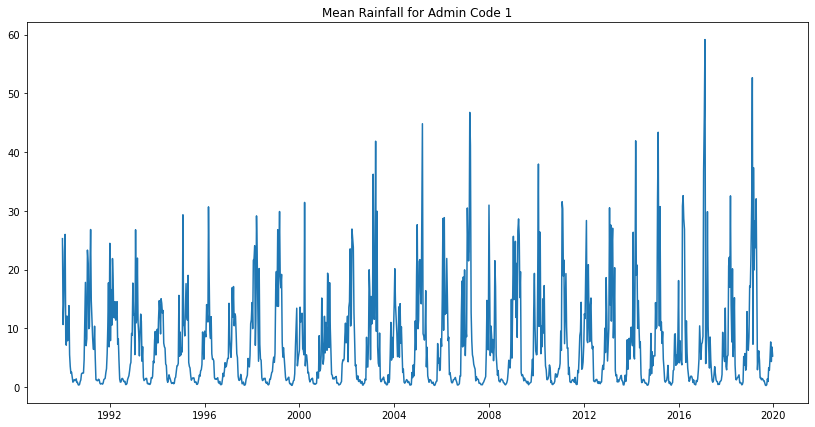

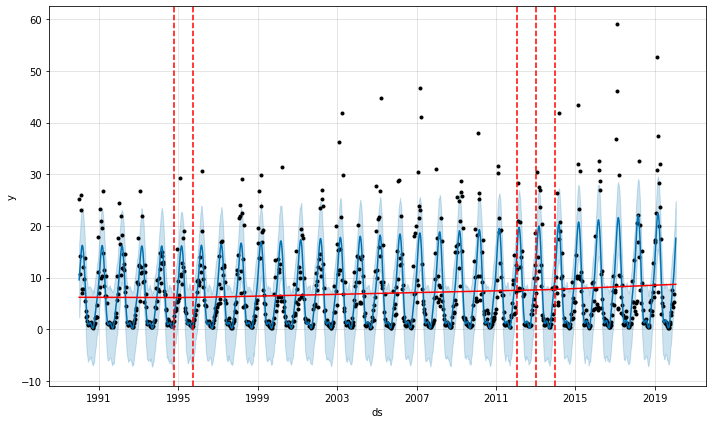

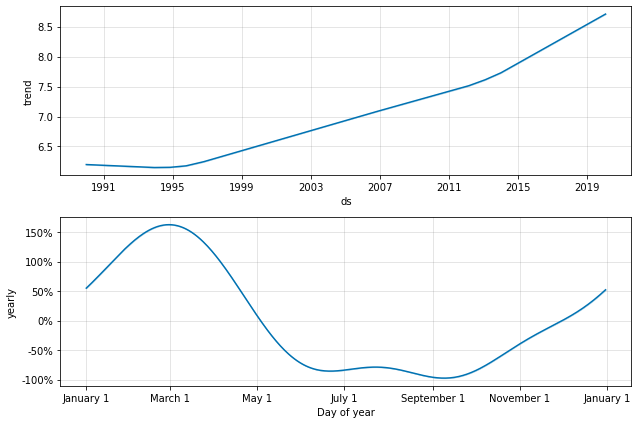

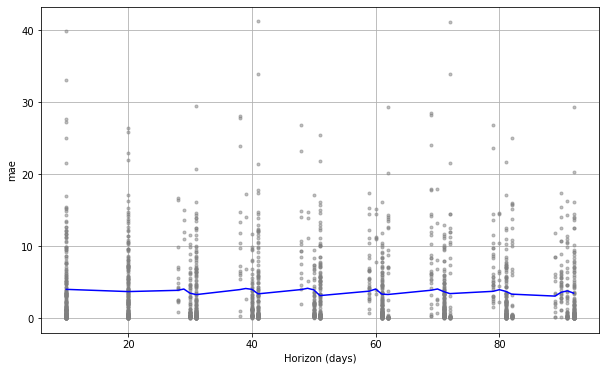

MAE: 3.68


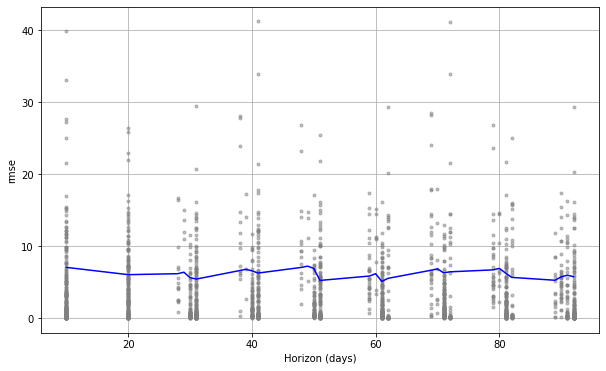

RMSE: 6.19
Admin Code: 2


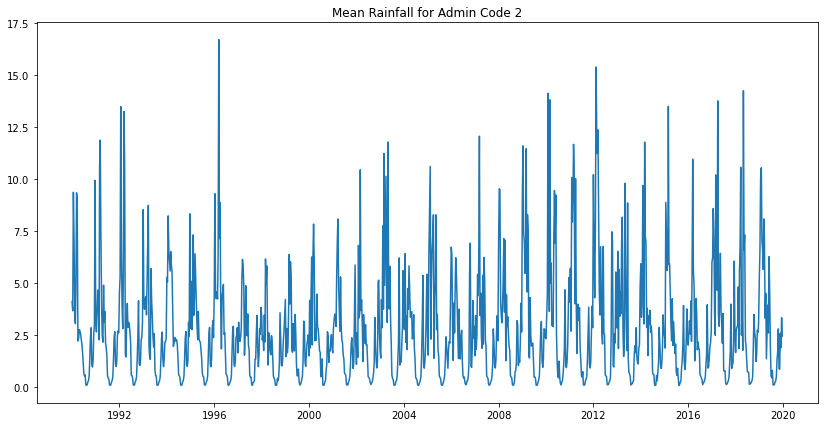

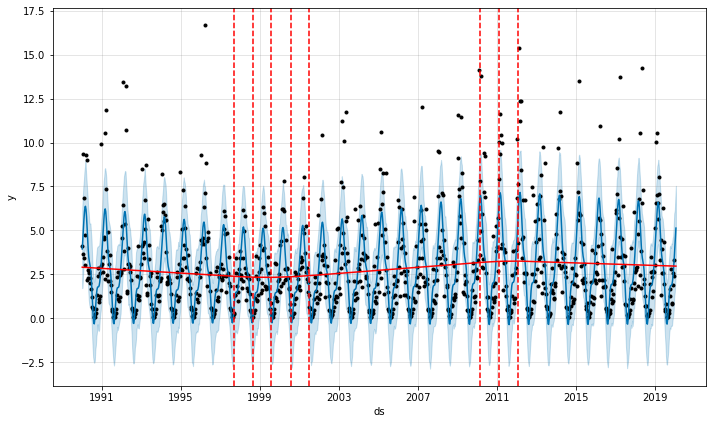

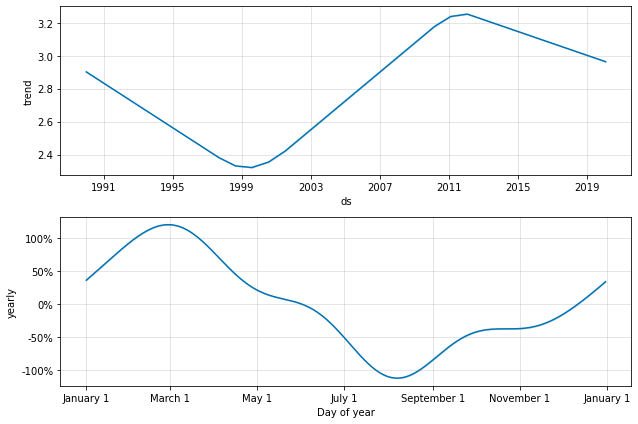

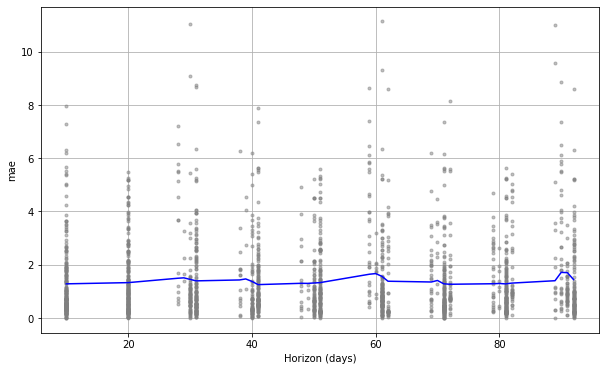

MAE: 1.41


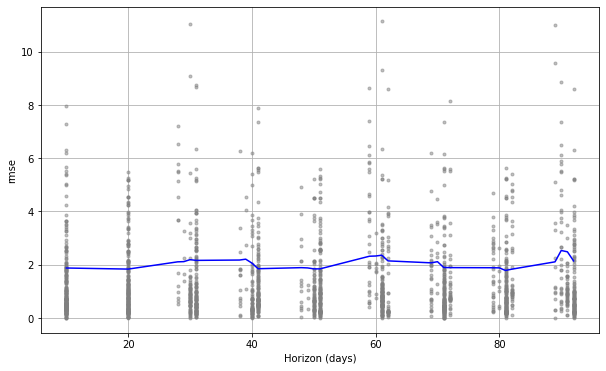

RMSE: 2.06
Admin Code: 147299


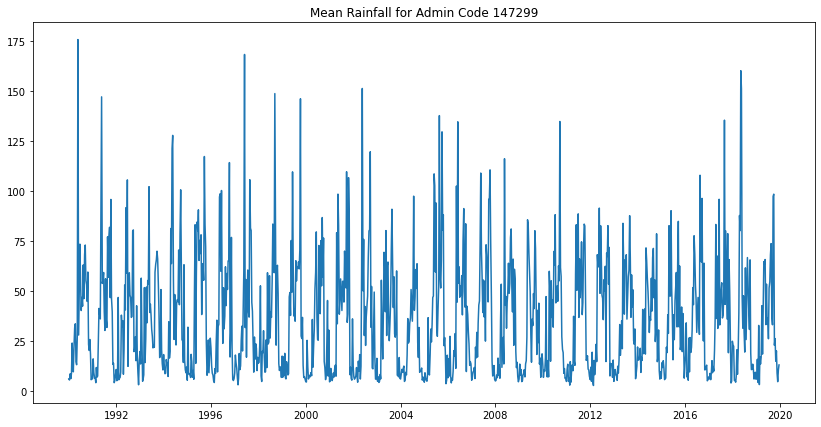

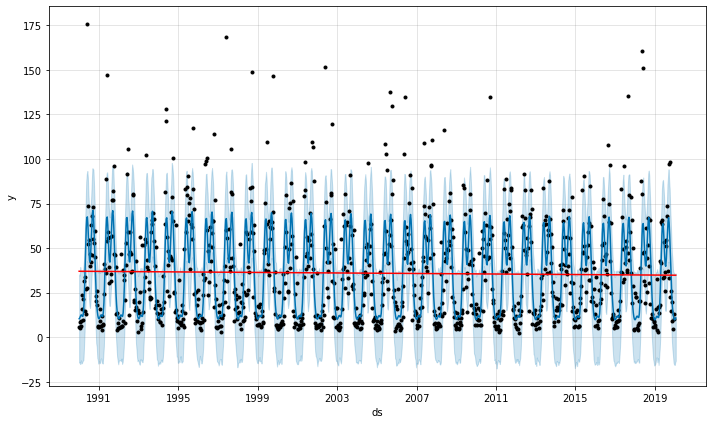

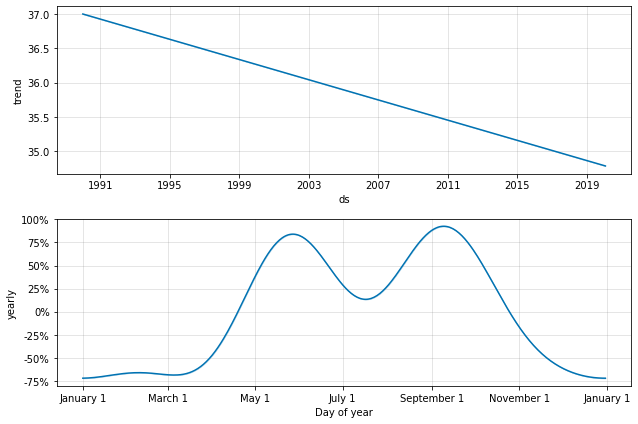

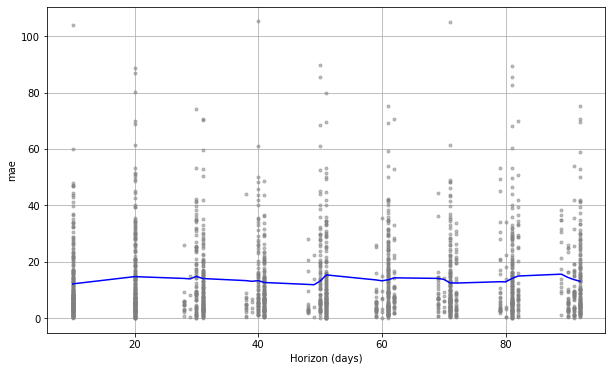

MAE: 13.54


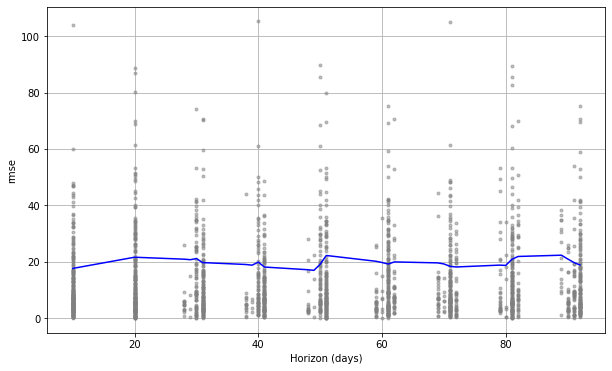

RMSE: 19.61
Admin Code: 257


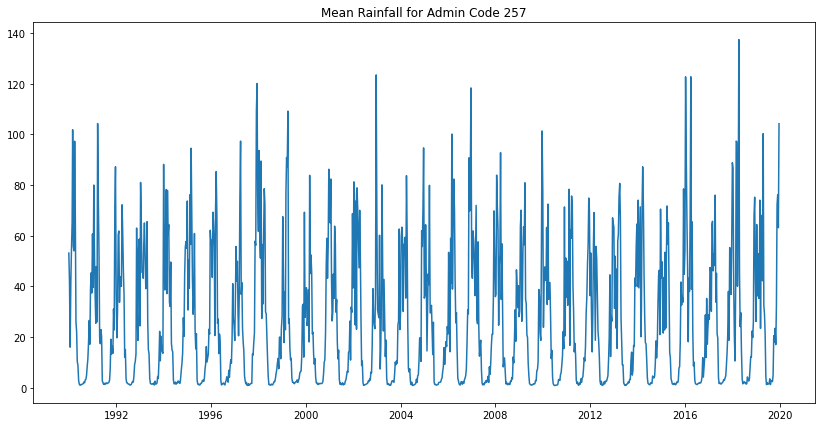

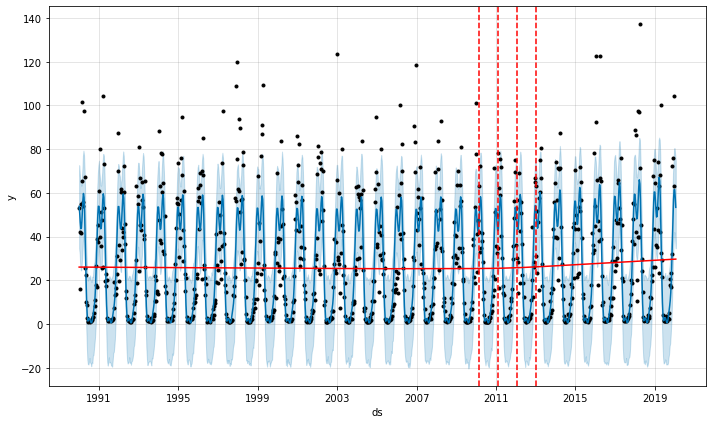

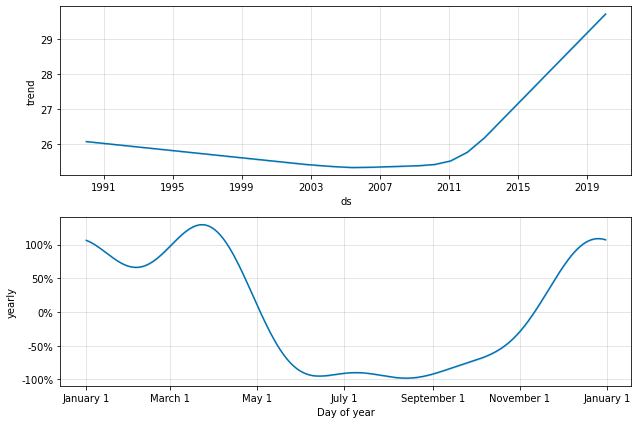

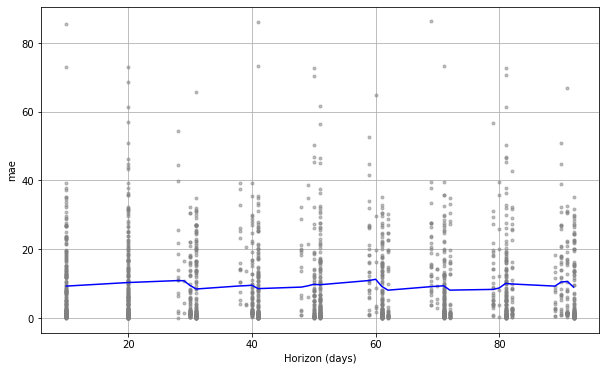

MAE: 9.51


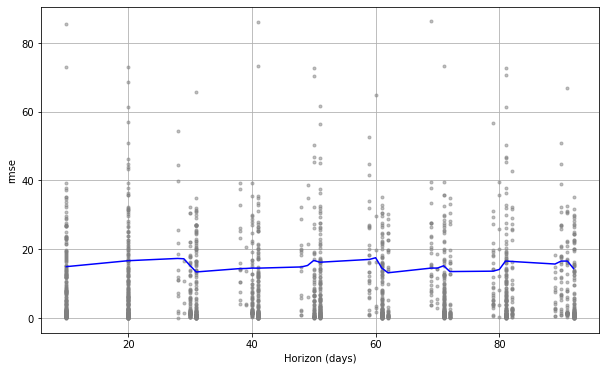

RMSE: 15.32
Admin Code: 188


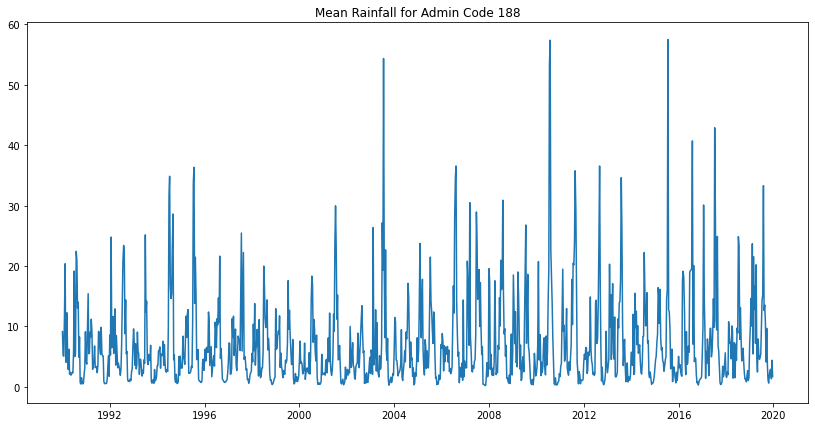

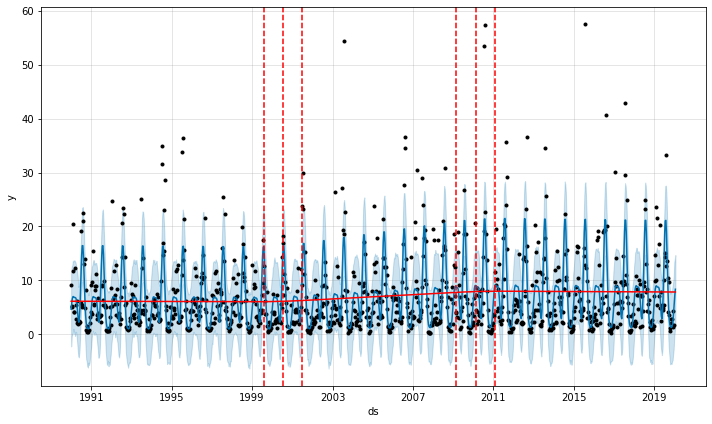

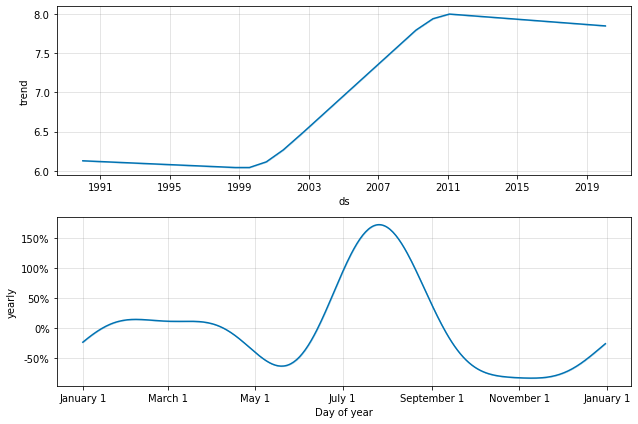

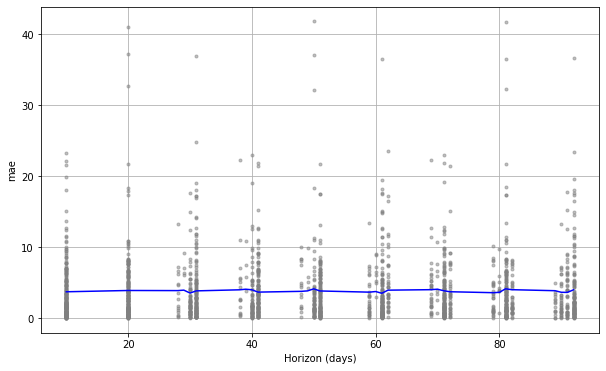

MAE: 3.82


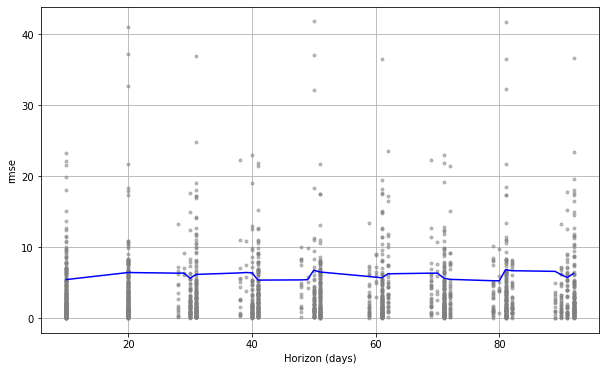

RMSE: 6.02
Admin Code: 61013


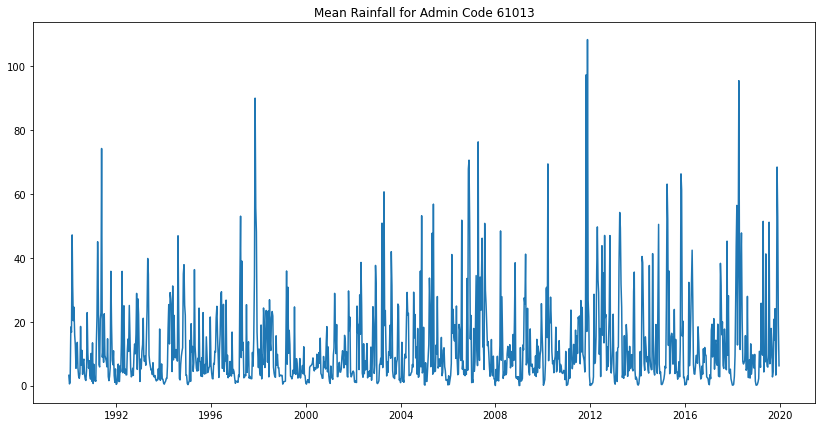

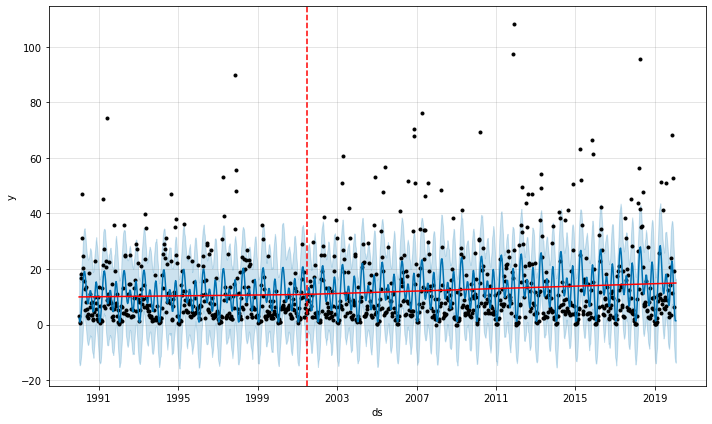

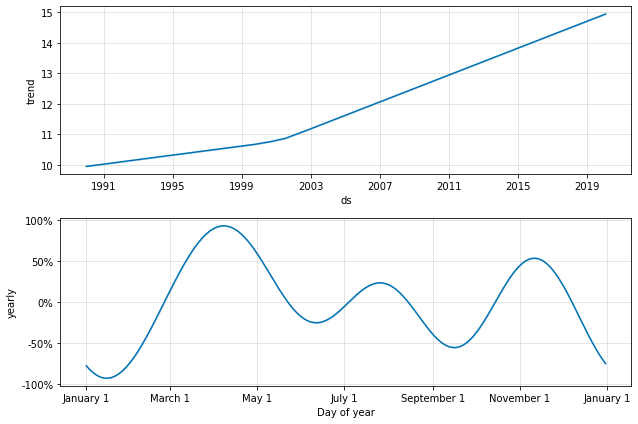

INFO:fbprophet:Skipping MAPE because y close to 0


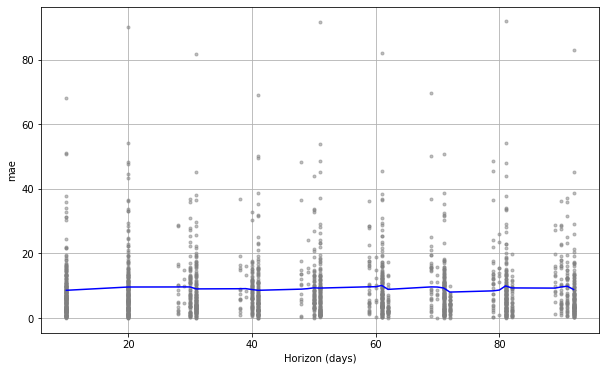

MAE: 9.23


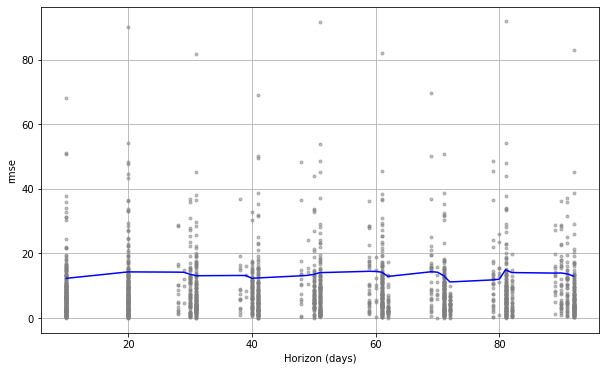

RMSE: 13.42
Admin Code: 54


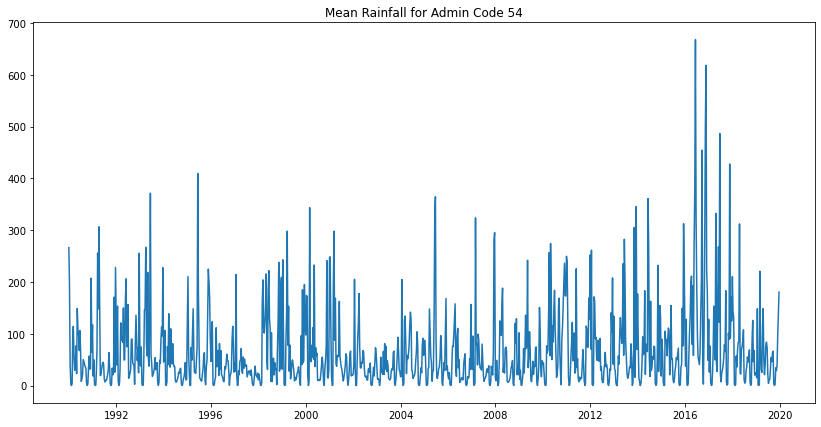

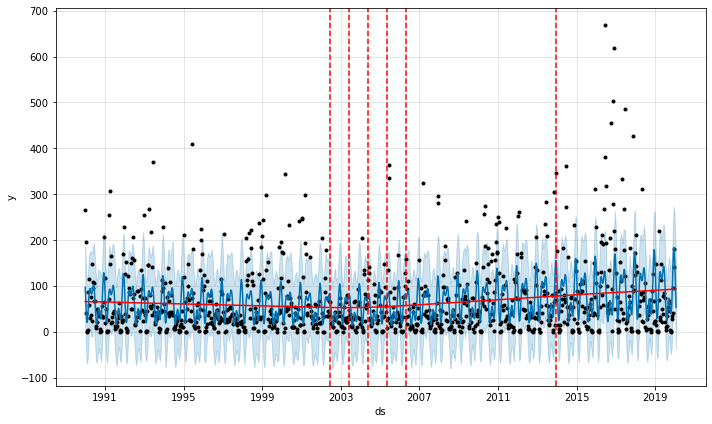

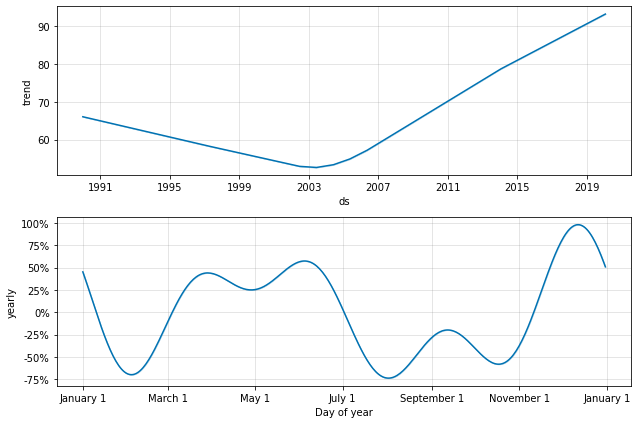

INFO:fbprophet:Skipping MAPE because y close to 0


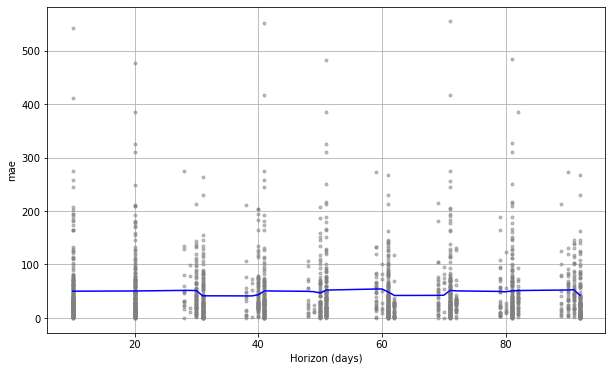

MAE: 48.60


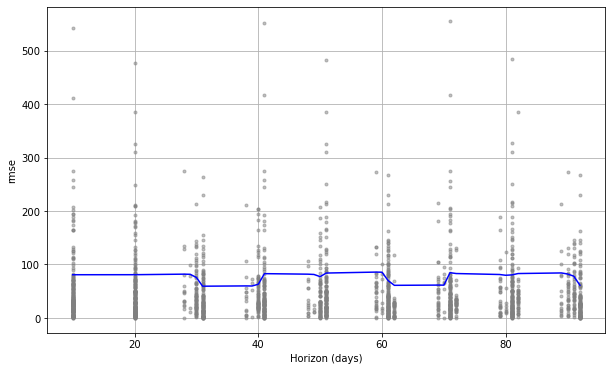

RMSE: 75.82
Admin Code: 149


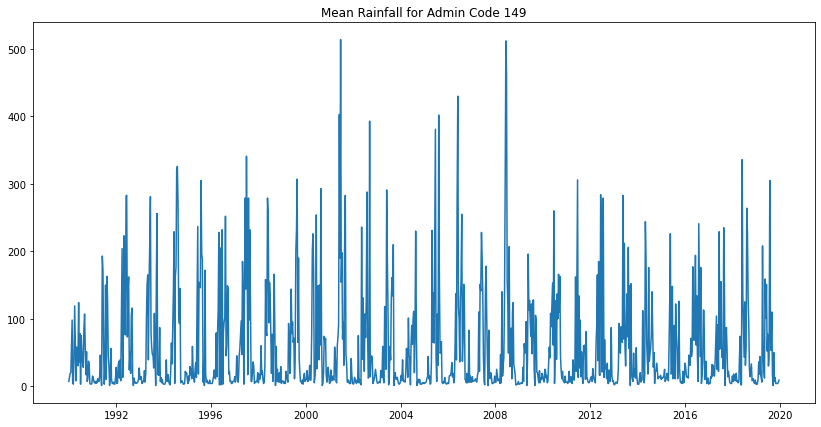

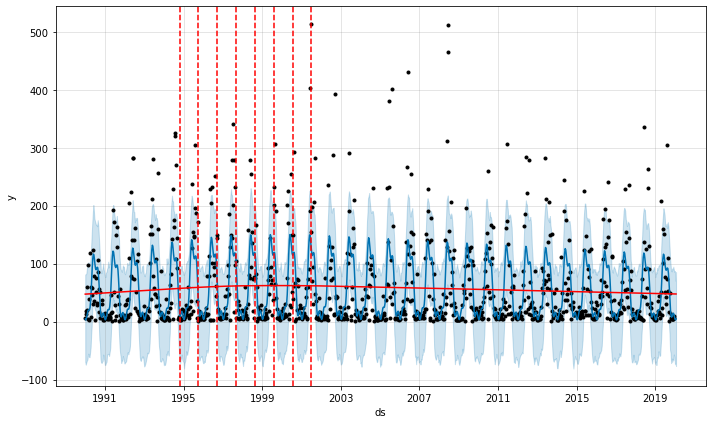

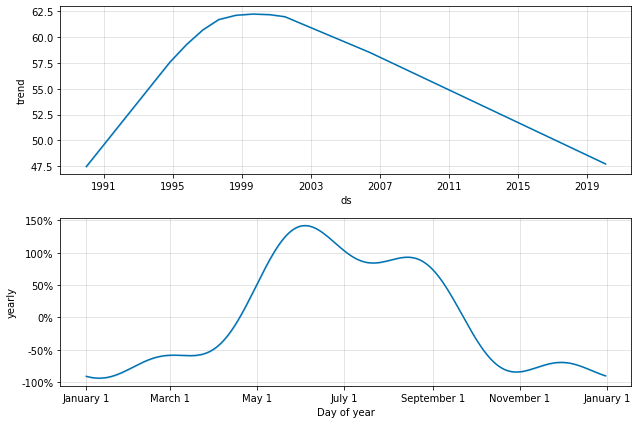

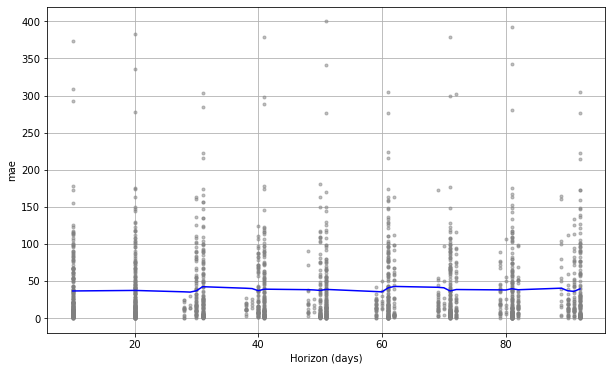

MAE: 38.21


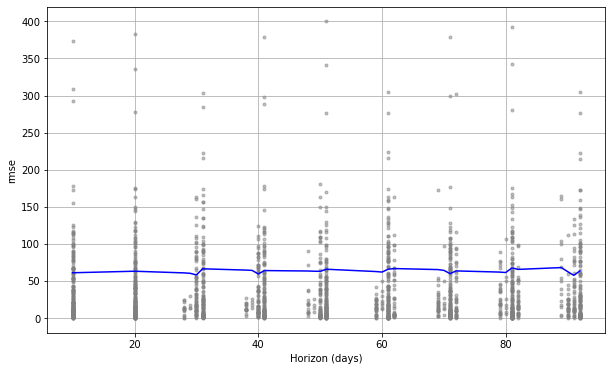

RMSE: 63.15
Admin Code: 56


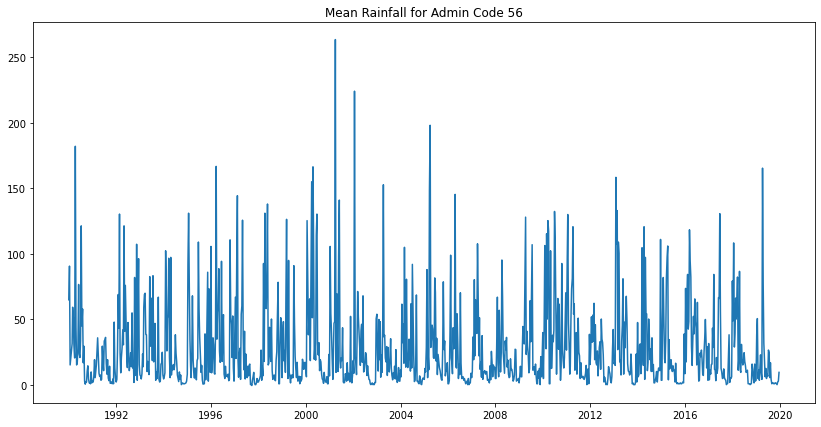

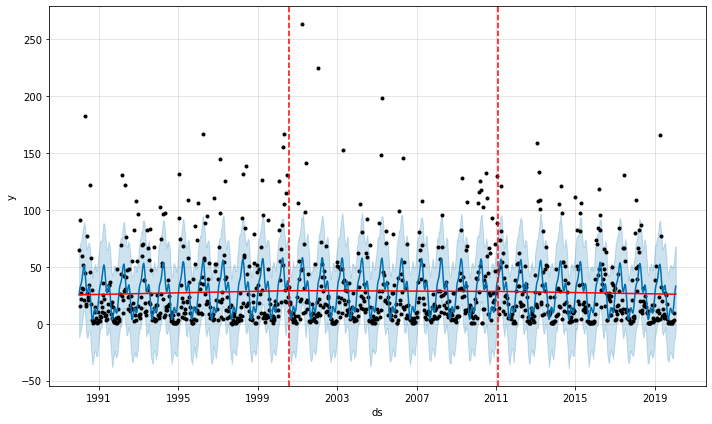

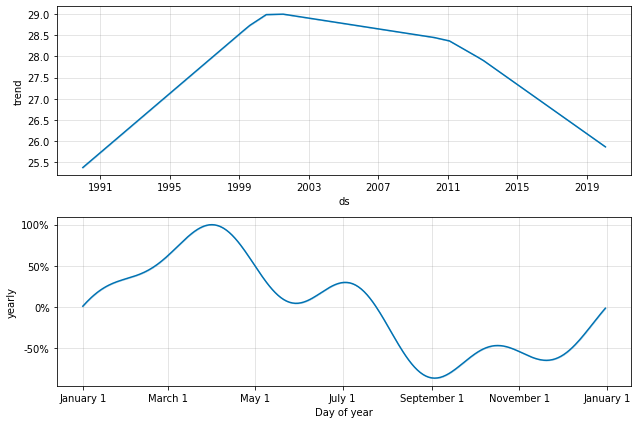

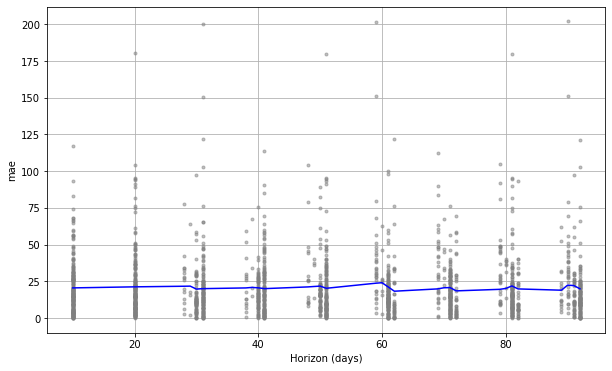

MAE: 20.73


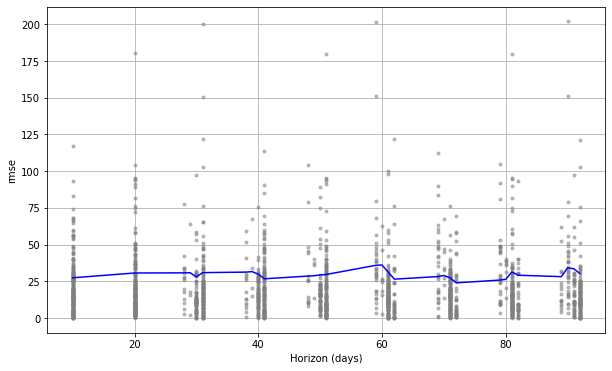

RMSE: 29.69
Admin Code: 40762


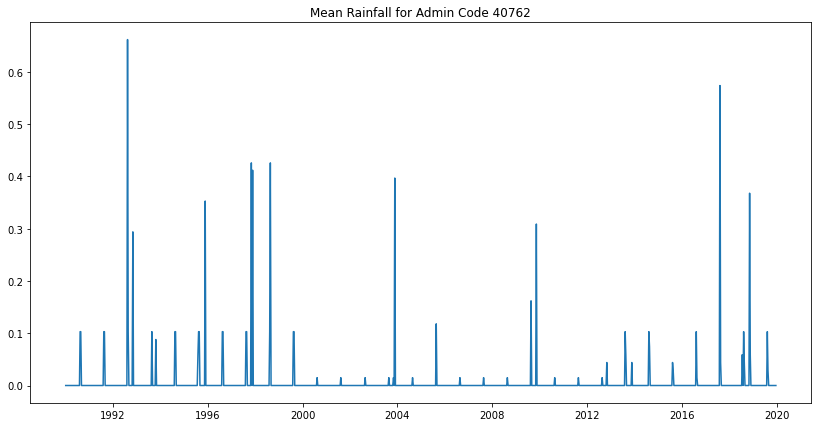

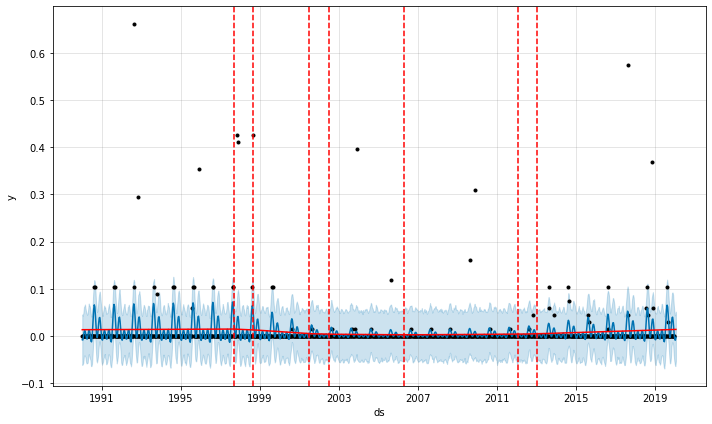

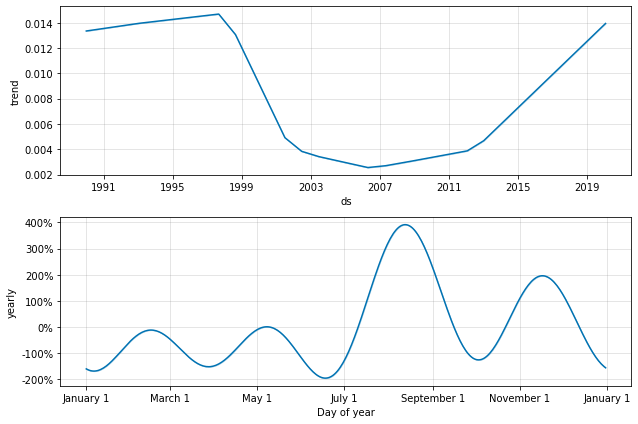

INFO:fbprophet:Skipping MAPE because y close to 0


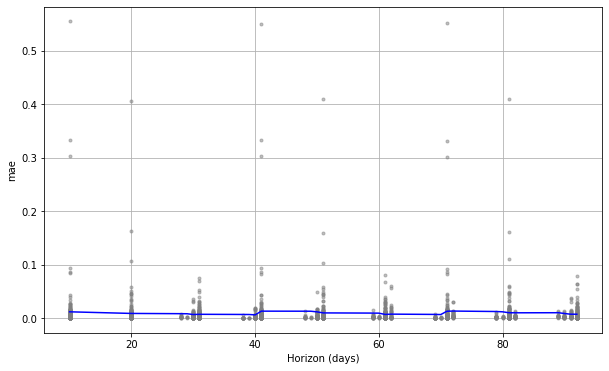

MAE: 0.01


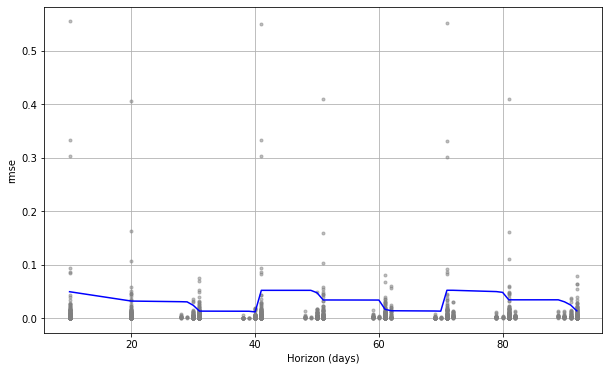

RMSE: 0.03
Admin Code: 252


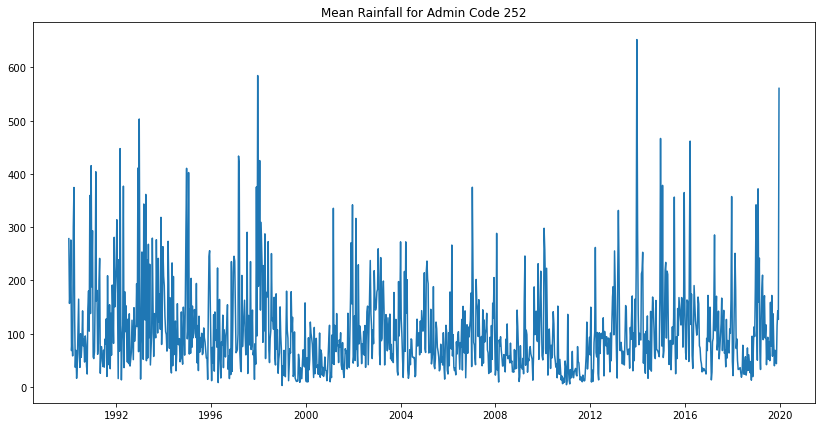

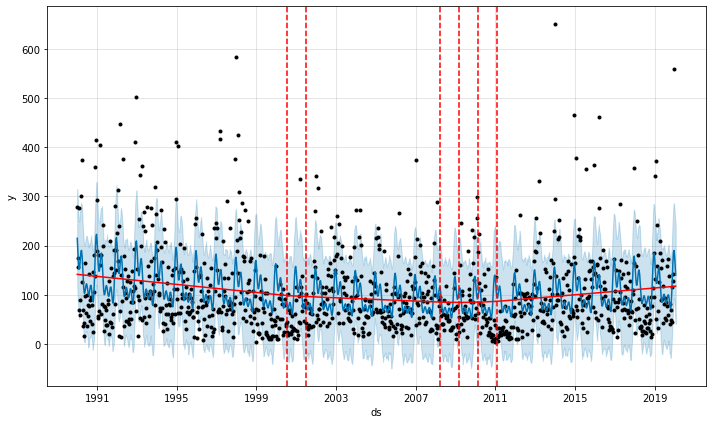

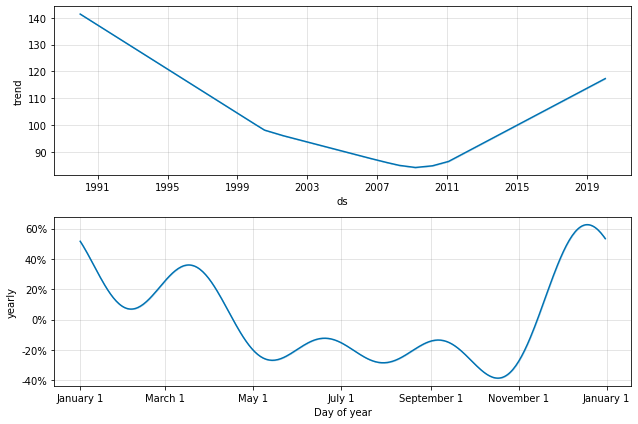

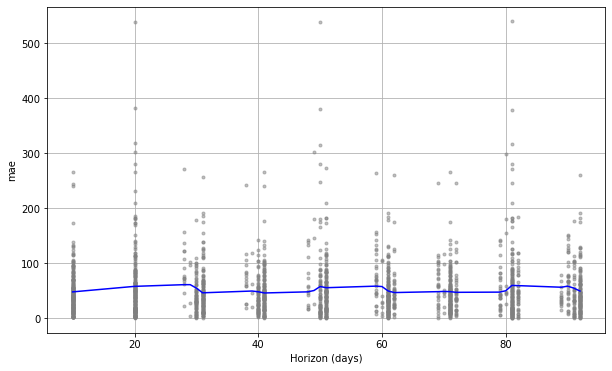

MAE: 52.01


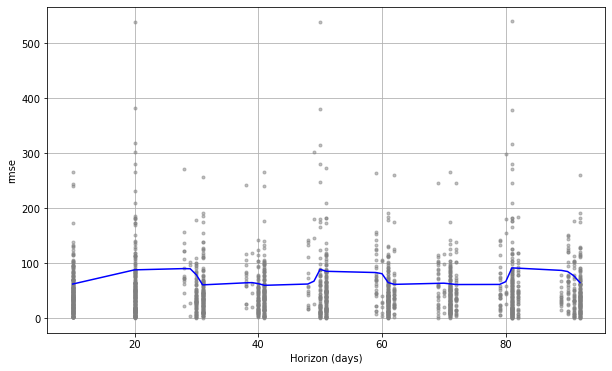

RMSE: 72.64


In [42]:
for code in set([k for (k, v) in sorted(models.items(), key=lambda x: x[0], reverse=True)][:2] +
                [k for (k, v) in sorted(models.items(), key=lambda x: x[0], reverse=True)][-2:] +
                max_rainfall +
                min_rainfall +
                median_rainfall +
                random.sample(data['AdminCode'].unique().tolist(), 3)):
    print('Admin Code: {}'.format(code))
    
    plt.figure(figsize=(14, 7))
    plt.plot(data[data['AdminCode'] == code]['date'], data[data['AdminCode'] ==code]['mean_rainfall'])
    plt.title('Mean Rainfall for Admin Code {}'.format(code))
    plt.show()
    
    df = pd.DataFrame()
    df['ds'] = data[data['AdminCode'] == code]['date']
    df['y'] = data[data['AdminCode'] == code]['mean_rainfall']

    prophet = Prophet(growth='linear',
                          yearly_seasonality=False,
                          weekly_seasonality=False,
                          daily_seasonality=False,
                          changepoint_prior_scale=.05,
                          mcmc_samples=0
                          ).add_seasonality(name='yearly',
                                            period=365.25,
                                            fourier_order=4,
                                            prior_scale=10,
                                            mode='multiplicative'
                          )

    prophet.fit(df)

    future = prophet.make_future_dataframe(periods=31, freq='D')
    future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

    forecast = prophet.predict(future)
    fig = prophet.plot(forecast)
    a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
    plt.show()

    fig2 = prophet.plot_components(forecast)
    plt.show()

    df_cv = cross_validation(prophet, horizon = '93 days', period='365 days', initial='3652 days', cutoffs=cutoffs)
    df_p = performance_metrics(df_cv)
    fig = plot_cross_validation_metric(df_cv, metric='mae')
    plt.show()
    print('MAE:', '{:.2f}'.format(df_p['mae'].mean()))
    fig = plot_cross_validation_metric(df_cv, metric='rmse')
    plt.show()
    print('RMSE:', '{:.2f}'.format(df_p['rmse'].mean()))
    print('====================================================================')

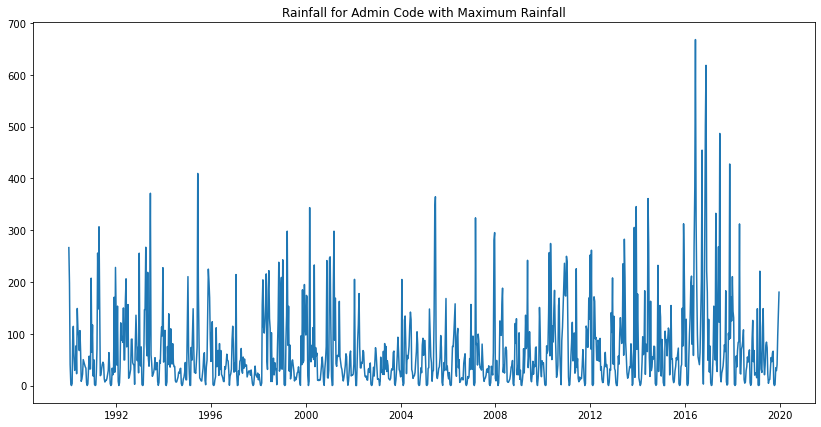

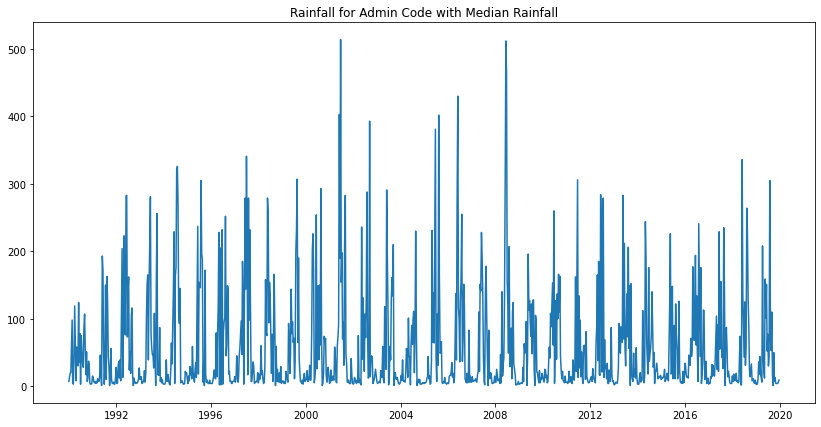

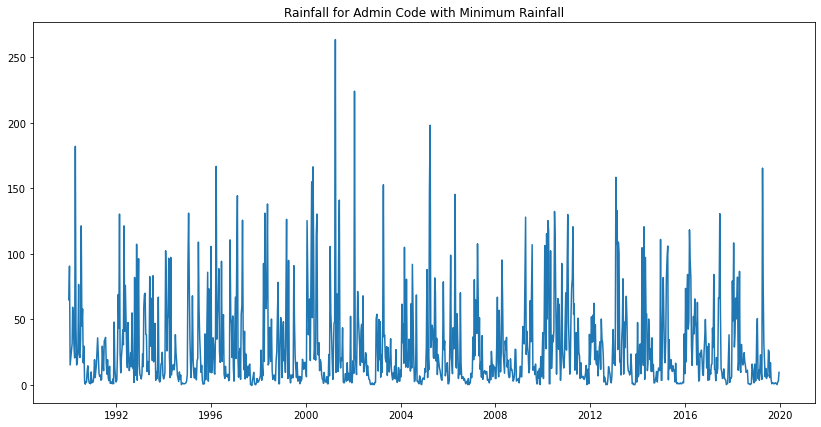

In [44]:
plt.figure(figsize=(14, 7))
plt.plot(data[data['AdminCode'] == max_rainfall[0]]['date'], data[data['AdminCode'] == max_rainfall[0]]['mean_rainfall'])
plt.title('Rainfall for Admin Code with Maximum Rainfall')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(data[data['AdminCode'] == median_rainfall[0]]['date'], data[data['AdminCode'] == median_rainfall[0]]['mean_rainfall'])
plt.title('Rainfall for Admin Code with Median Rainfall')
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(data[data['AdminCode'] == min_rainfall[0]]['date'], data[data['AdminCode'] == min_rainfall[0]]['mean_rainfall'])
plt.title('Rainfall for Admin Code with Minimum Rainfall')
plt.show()

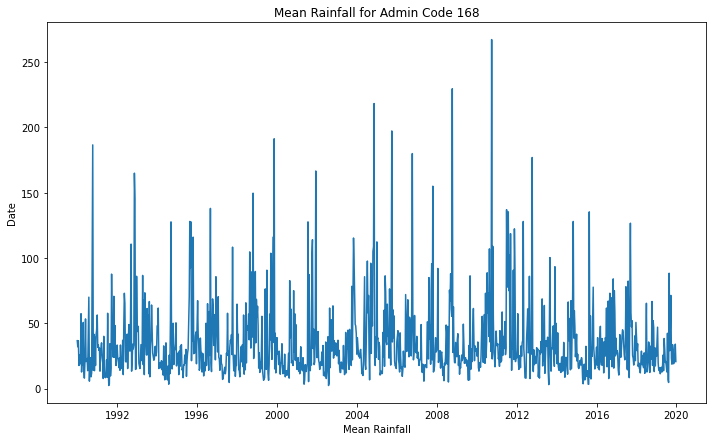

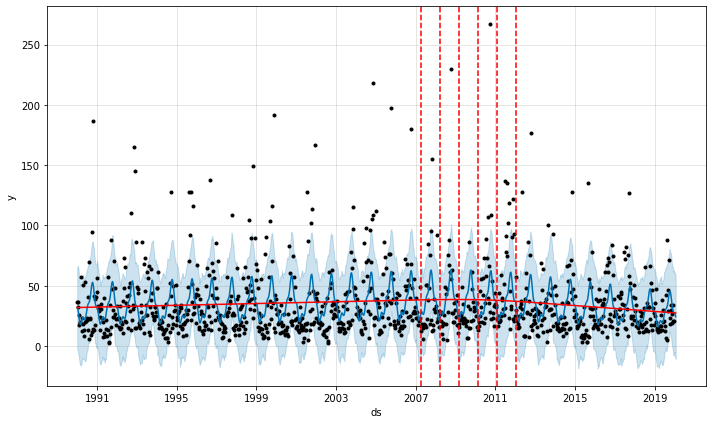

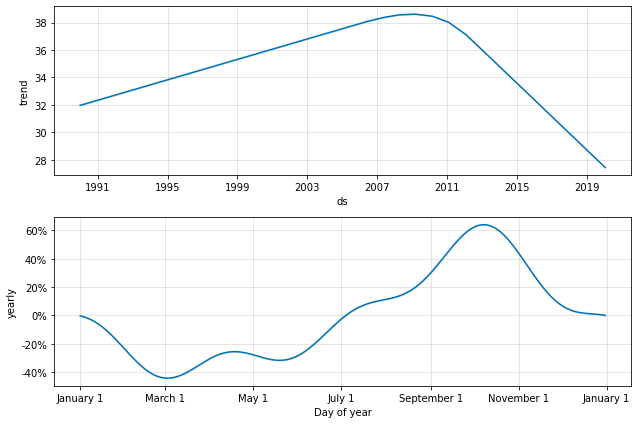

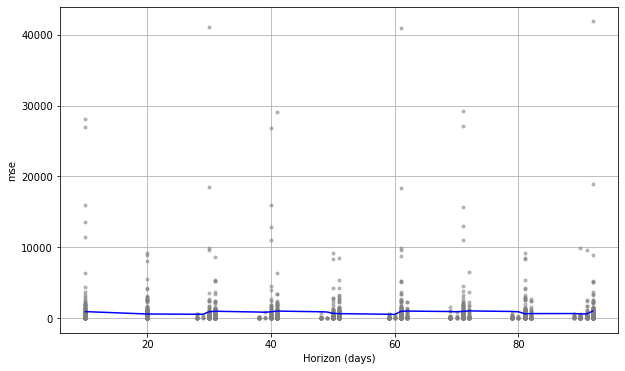

MSE: 774.95


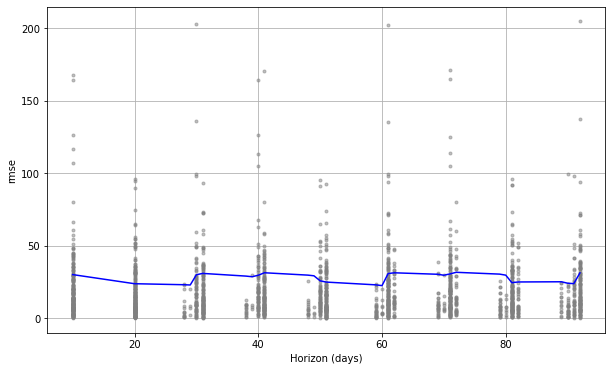

RMSE: 27.66


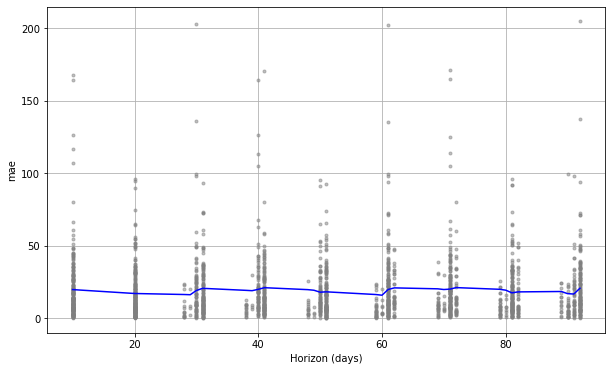

MAE: 18.73


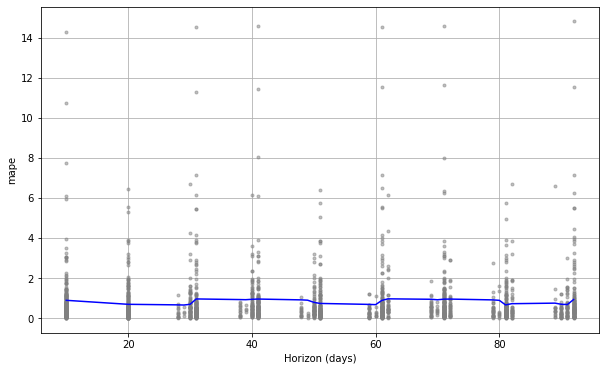

MAPE: 0.82


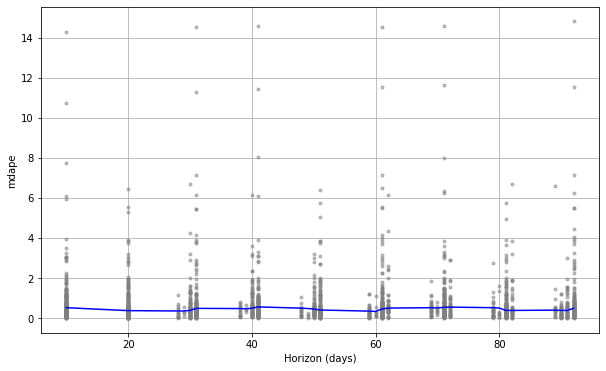

MDAPE: 0.45


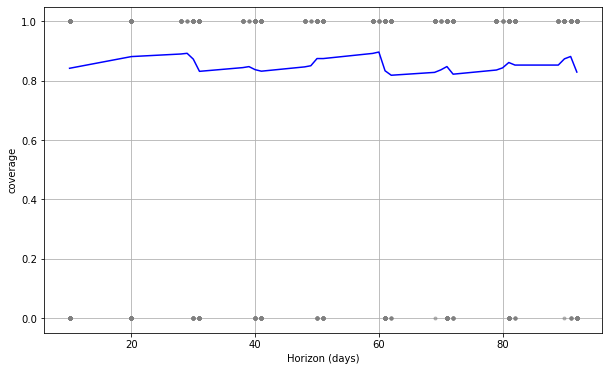

COVERAGE: 0.85


In [45]:
code = 168
    
plt.figure(figsize=(11.8, 7))
plt.plot(data[data['AdminCode'] == code]['date'], data[data['AdminCode'] ==code]['mean_rainfall'])
plt.title('Mean Rainfall for Admin Code {}'.format(code))
plt.xlabel('Mean Rainfall')
plt.ylabel('Date')
plt.show()

df = pd.DataFrame()
df['ds'] = data[data['AdminCode'] == code]['date']
df['y'] = data[data['AdminCode'] == code]['mean_rainfall']

prophet = Prophet(growth='linear',
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      changepoint_prior_scale=.05,
                      mcmc_samples=0
                      ).add_seasonality(name='yearly',
                                        period=365.25,
                                        fourier_order=4,
                                        prior_scale=10,
                                        mode='multiplicative'
                      )

prophet.fit(df)

future = prophet.make_future_dataframe(periods=31, freq='D')
future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

fig2 = prophet.plot_components(forecast)
plt.show()

df_cv = cross_validation(prophet, horizon = '93 days', period='365 days', initial='3652 days', cutoffs=cutoffs)
df_p = performance_metrics(df_cv)

for metric in ['mse', 'rmse', 'mae', 'mape', 'mdape', 'coverage']:
    fig = plot_cross_validation_metric(df_cv, metric=metric)
    plt.show()
    print('{}: {:.2f}'.format(metric.upper(), df_p[metric].mean()))

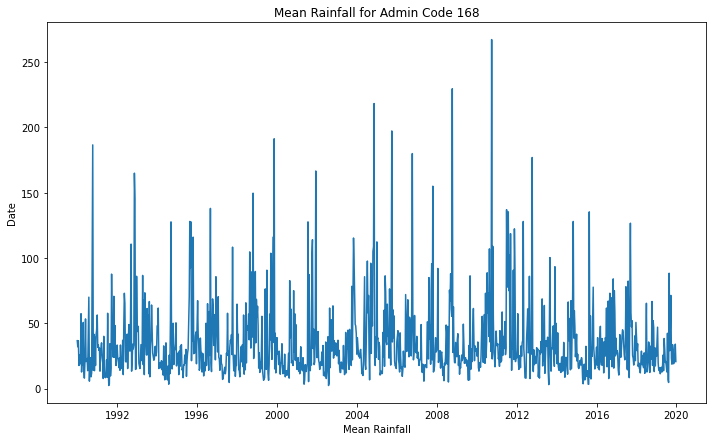

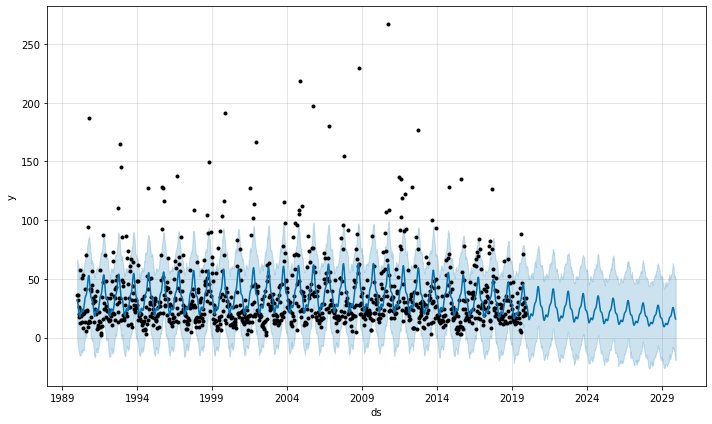

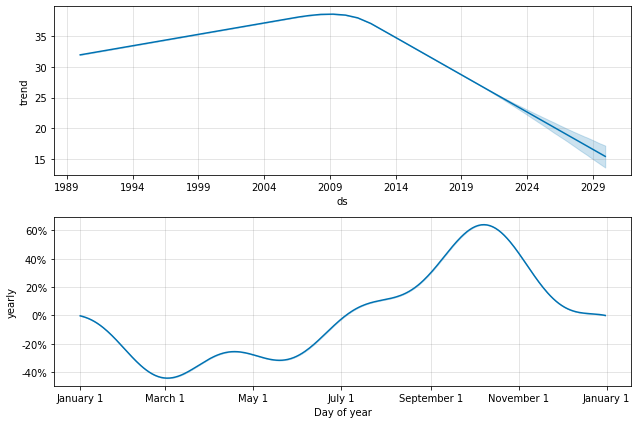

In [46]:
code = 168
    
plt.figure(figsize=(11.8, 7))
plt.plot(data[data['AdminCode'] == code]['date'], data[data['AdminCode'] ==code]['mean_rainfall'])
plt.title('Mean Rainfall for Admin Code {}'.format(code))
plt.xlabel('Mean Rainfall')
plt.ylabel('Date')
plt.show()

df = pd.DataFrame()
df['ds'] = data[data['AdminCode'] == code]['date']
df['y'] = data[data['AdminCode'] == code]['mean_rainfall']

prophet = Prophet(growth='linear',
                      yearly_seasonality=False,
                      weekly_seasonality=False,
                      daily_seasonality=False,
                      changepoint_prior_scale=.05,
                      mcmc_samples=0
                      ).add_seasonality(name='yearly',
                                        period=365.25,
                                        fourier_order=4,
                                        prior_scale=10,
                                        mode='multiplicative'
                      )

prophet.fit(df)

future = prophet.make_future_dataframe(periods=3652, freq='D')
future = future[(future['ds'].astype(str).str[-1] == '1') & (future['ds'].astype(str).str[-2] != '3')]

forecast = prophet.predict(future)
fig = prophet.plot(forecast)
# a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()

fig2 = prophet.plot_components(forecast)
plt.show()